# Neighborhood enrichment test on image data

This tutorial explains how to conduct a neighborhood enrichment test (see [Wählby et al. (2022)](https://www.frontiersin.org/articles/10.3389/fphys.2022) for explanation) on image data with napari-spatial-statistics. This function uses the [Squidpy](https://squidpy.readthedocs.io/en/stable/index.html) spatial statistics platform.

In [1]:
import napari 
import napari_spatial_statistics as nss
import matplotlib.pyplot as plt
import pandas as pd

### Non-random spots

We first create some sample data and add a small amount of "randomness" to it so that the locations of multiple types of objects are close to each other, but not directly on top of each other.

In [2]:
spots = nss.make_random_spots(n_spots=1000, n_classes=2, spatial_size=500, dim=3, sigma=2.5, randomness=10)

e:\biapol\projects\napari-spatial-statistics\src\napari_spatial_statistics\_sample_data.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[[locations[:, i] for i in range(locations.shape[1])]] = 1


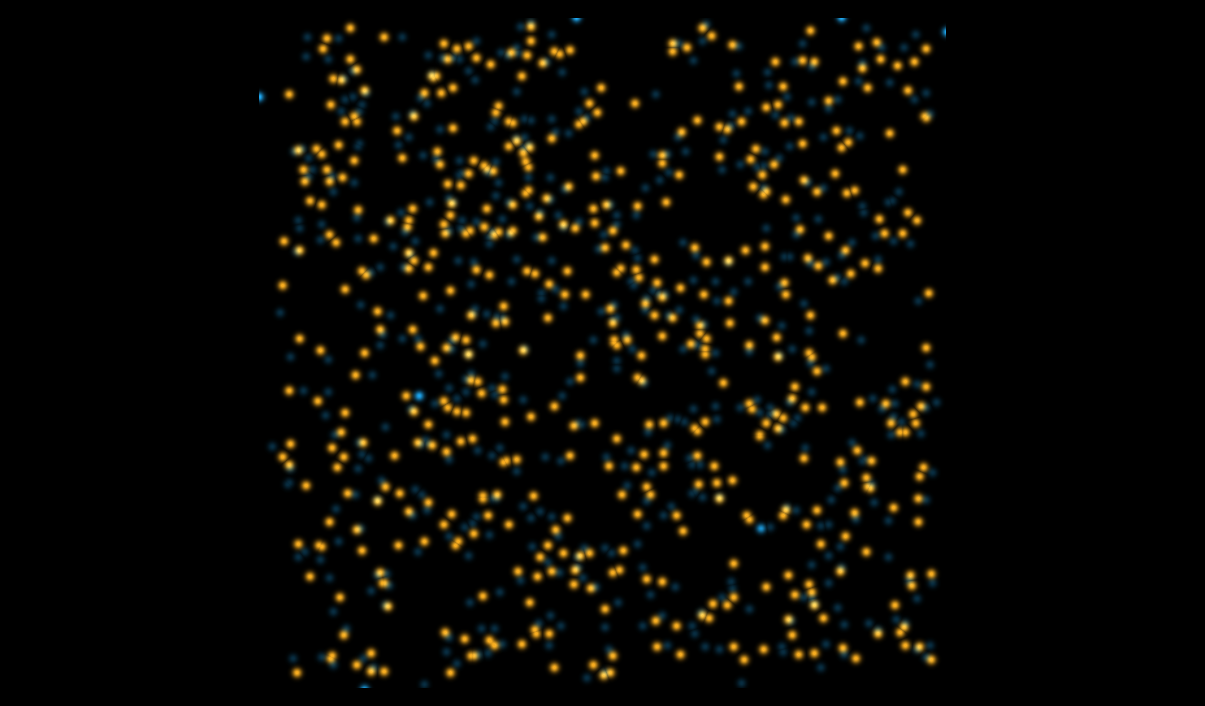

In [3]:
viewer = napari.Viewer(ndisplay=3)

for spot in spots:
    viewer.add_image(spot[0], **spot[1], blending='additive')
    
napari.utils.nbscreenshot(viewer, canvas_only=True)

Now we try to detect the location of the spots and put them into a separate points layer for each color channel:

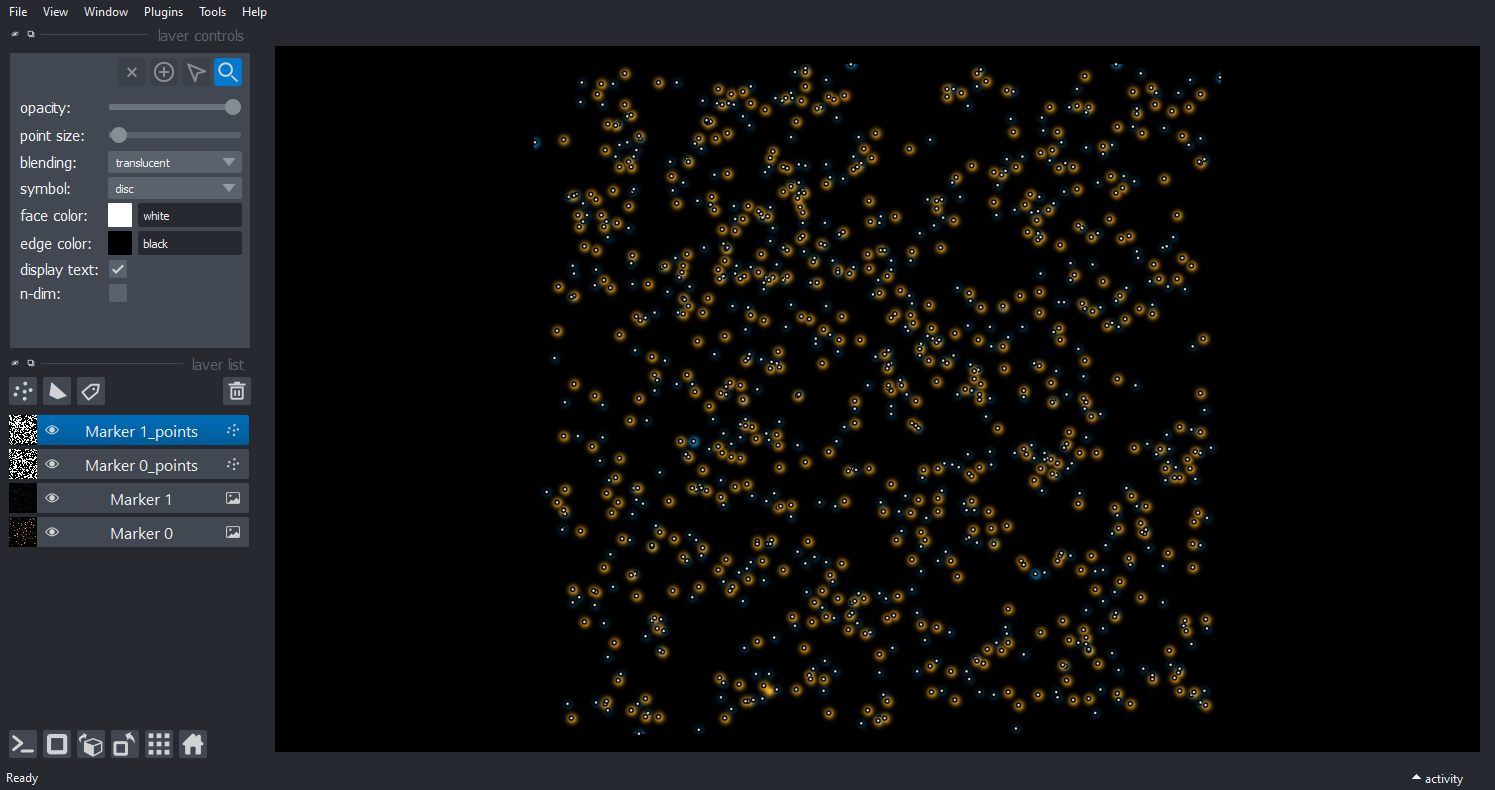

In [4]:
maxima_layers = []
for spot in spots:
    maxima = nss.detect_maxima(spot[0], threshold_value=0.25, exclude_border=False, minimal_distance=5)
    maxima_layers.append(viewer.add_points(maxima, name=spot[1]['name'] + '_points', size=3.0))
    
napari.utils.nbscreenshot(viewer)

Since the neighborhood enrichment test and the neighborhood determination operates on single points layers, we will merge the created points layers into a single layer and store the point identities into `layer.properties`:

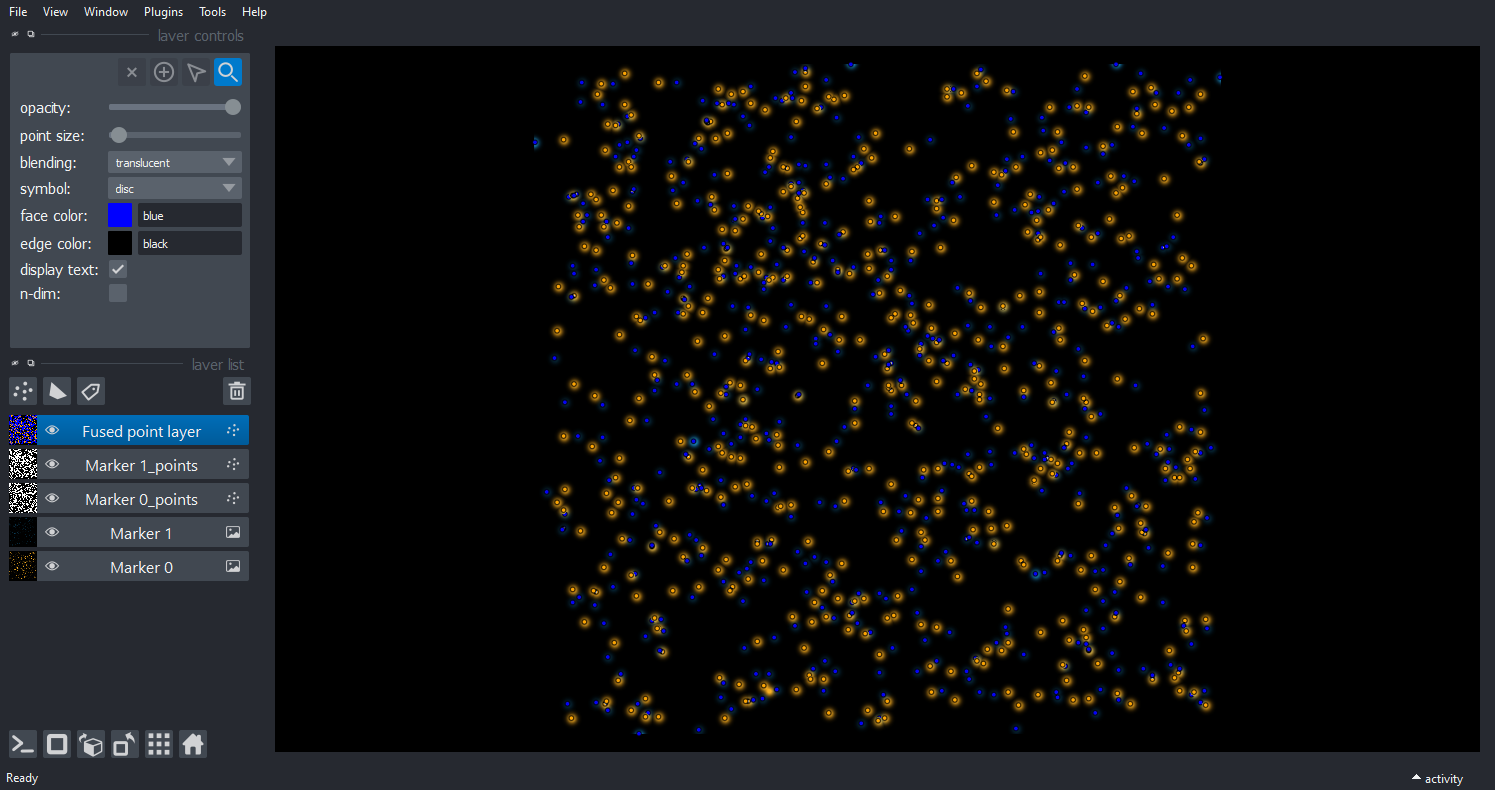

In [5]:
points_merged = nss.merge_points_layers(viewer)
viewer.add_points(points_merged[0], **points_merged[1])
napari.utils.nbscreenshot(viewer, canvas_only=False)

Similarly to [this notebook]('./Neighborhood_enrichment_test_points'), we can now determine the neighborhood between the points with a method of our choice:
    
* `nss.distance_ckdtree()`: Distance-based neighborhood implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html)
* `nss.distance_squidpy()`: Distance-based neighborhood implement in [Squidpy](https://squidpy.readthedocs.io/en/stable/auto_examples/graph/compute_spatial_neighbors.html)
* `nss.knearest_ckdtree()`: N-nearest neighbors implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query)

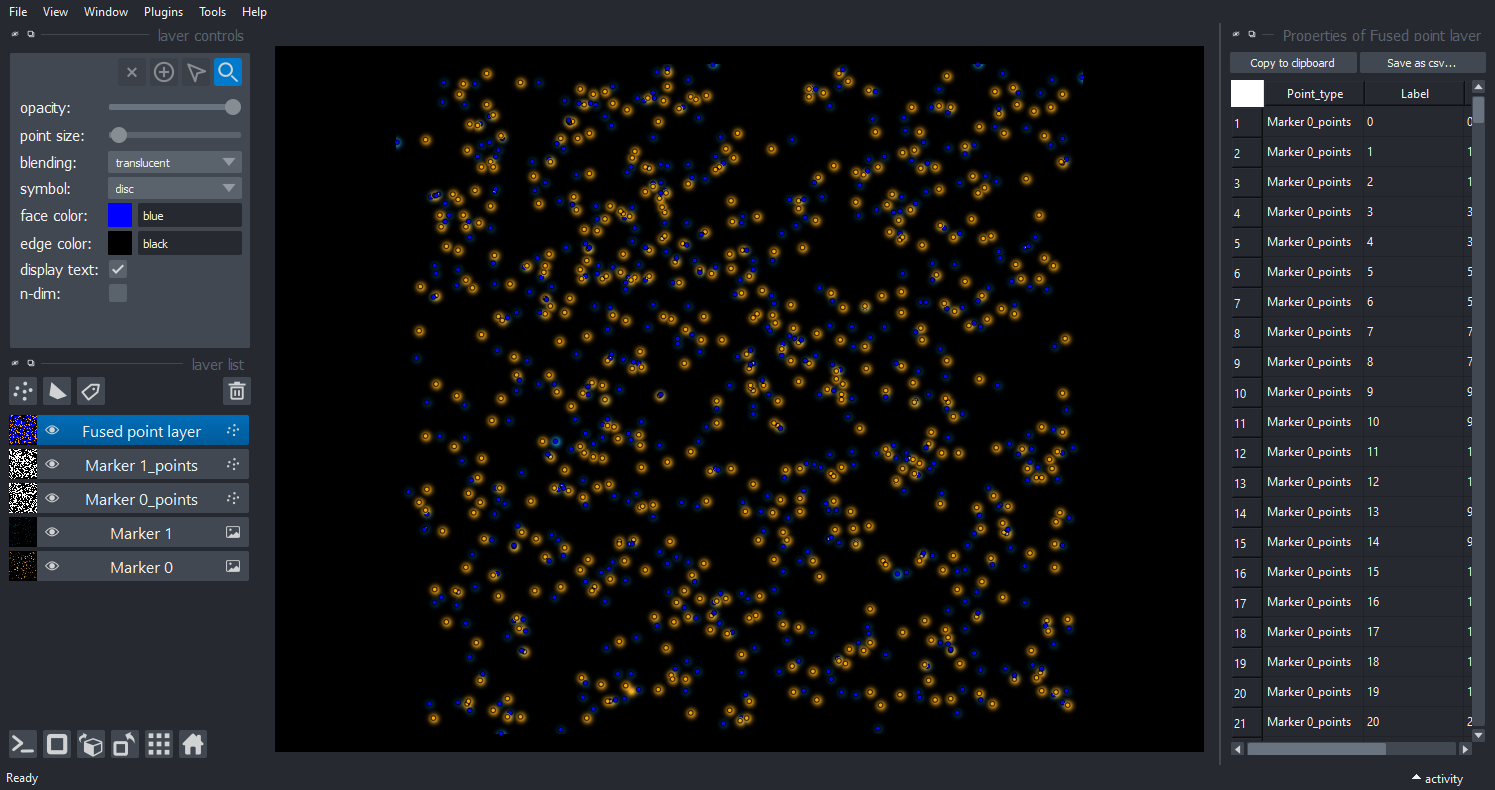

In [6]:
properties = nss.distance_ckdtree(points_merged, radius=20, viewer=viewer)
napari.utils.nbscreenshot(viewer, canvas_only=False)

*Note*: using the `merge_points_layers()` function reads the name of ach points layer and adds a column `Point_type` to the `layer.properties` of the merged layer which tells from which layer the respective point comes from. The widget on the right hand side is simply a view on `points_merged.properties`:

In [7]:
pd.DataFrame(properties)

Point_type  Label    neighbors
0    Marker 0_points      0    0,514,515
1    Marker 0_points      1      1,2,994
2    Marker 0_points      2  1,2,979,994
3    Marker 0_points      3  3,4,901,970
4    Marker 0_points      4  3,4,901,970
..               ...    ...          ...
994  Marker 1_points    994      1,2,994
995  Marker 1_points    995      484,995
996  Marker 1_points    996      494,996
997  Marker 1_points    997      397,997
998  Marker 1_points    998  415,930,998

[999 rows x 3 columns]

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.42/s]


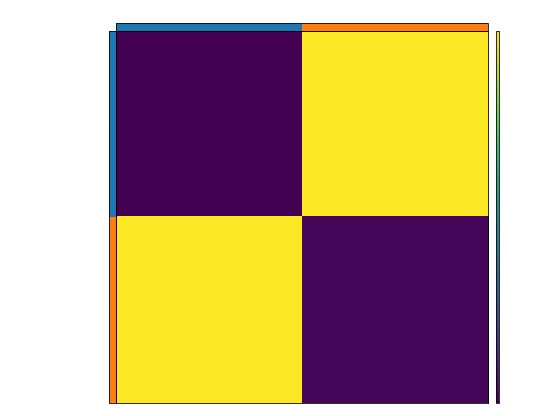

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
results = nss.neighborhood_enrichment_test(points_merged[0], properties=properties, on_feature='Point_type', n_permutations=1000, ax=ax)

Again, we can see that the spots of the two types `Marker 1_points` and `Marker 2_points` appear spatially over-enriched in each other's immediate neighborhood.

### Random spots

We can repeat the above analysis with a higher amount of "randomness" to see how this is reflected in the neighborhood enrichment analysis:

In [9]:
viewer2 = napari.Viewer(ndisplay=3)
spots = nss.make_random_spots(n_spots=1000, n_classes=2, spatial_size=500, dim=3, sigma=2.5, randomness=50)

e:\biapol\projects\napari-spatial-statistics\src\napari_spatial_statistics\_sample_data.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[[locations[:, i] for i in range(locations.shape[1])]] = 1


In [10]:
# Detect maxima
maxima_layers = []
for spot in spots:
    maxima = nss.detect_maxima(spot[0], threshold_value=0.25, exclude_border=False, minimal_distance=5)
    maxima_layers.append(viewer2.add_points(maxima, name=spot[1]['name'] + '_points', size=3.0))
    
points_merged = nss.merge_points_layers(viewer2)
viewer2.add_points(points_merged[0], **points_merged[1])

<Points layer 'Fused point layer' at 0x1af54f291f0>

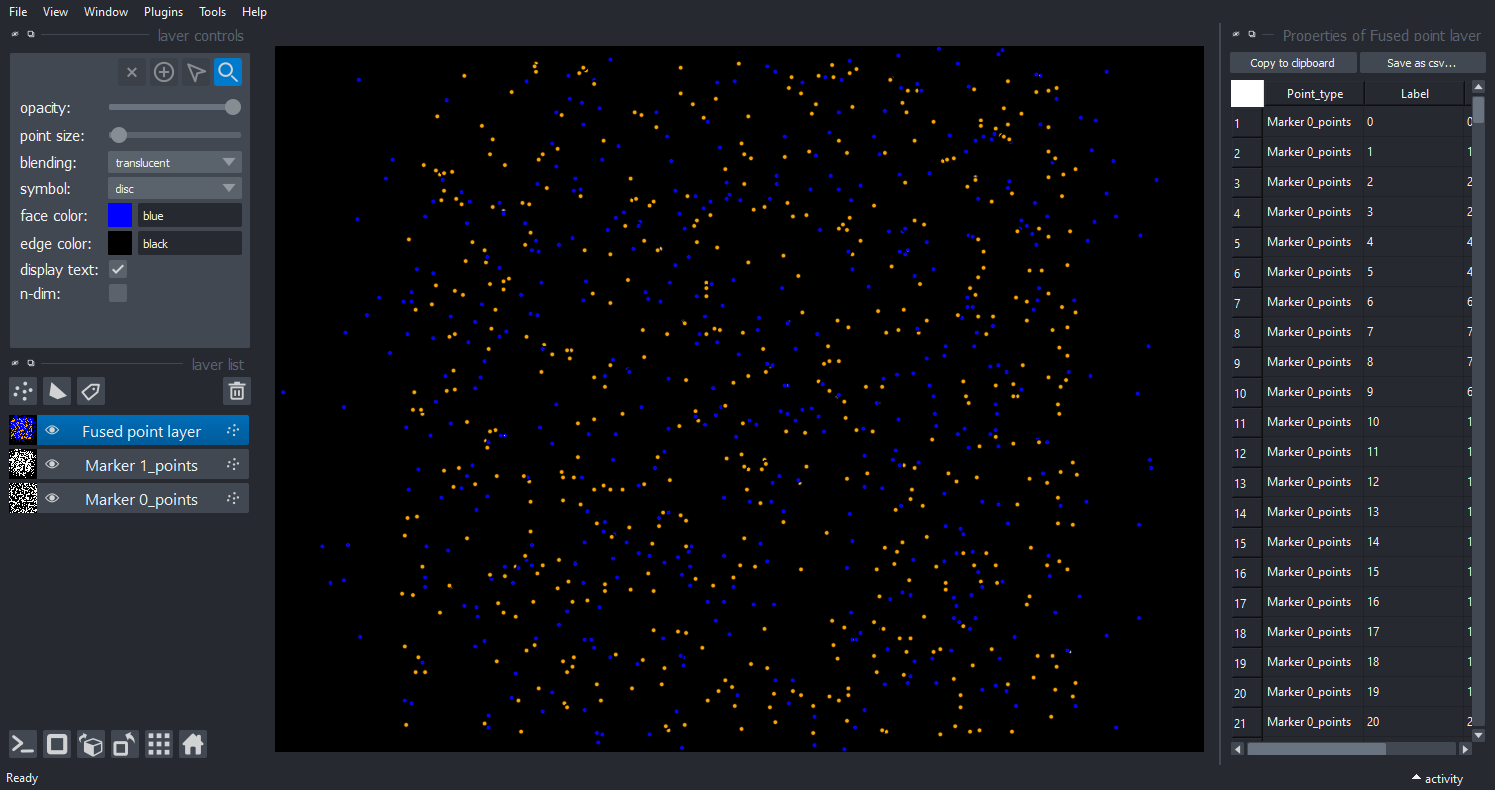

In [11]:
# Get neighborhood
properties = nss.distance_ckdtree(points_merged, radius=20, viewer=viewer2)
napari.utils.nbscreenshot(viewer2, canvas_only=False)

In [12]:
pd.DataFrame(properties)

Point_type  Label    neighbors
0    Marker 0_points      0            0
1    Marker 0_points      1            1
2    Marker 0_points      2          2,3
3    Marker 0_points      3          2,3
4    Marker 0_points      4          4,5
..               ...    ...          ...
993  Marker 1_points    993  949,967,993
994  Marker 1_points    994      467,994
995  Marker 1_points    995          995
996  Marker 1_points    996          996
997  Marker 1_points    997          997

[998 rows x 3 columns]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.25/s]


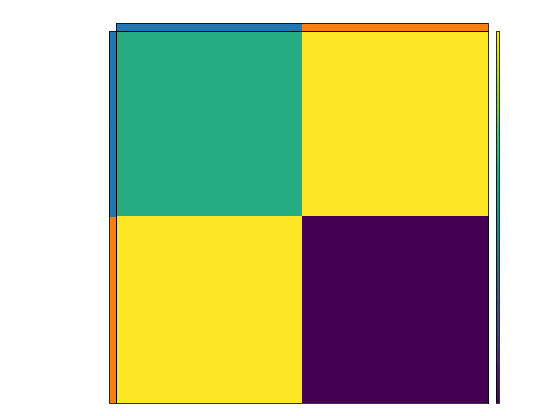

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
results = nss.neighborhood_enrichment_test(points_merged[0], properties=properties, on_feature='Point_type', n_permutations=1000, ax=ax)

You can appreciate that the neighborhood enrichment scores are considerably closer to zero (no over-enrichment/over-depletion) for the data with more randomness than for the example above.